In [1]:
from pathlib import Path
import sys
project_root = next((parent for parent in [Path.cwd()] + list(Path.cwd().parents) if (parent / "pyproject.toml").exists()), Path.cwd())
sys.path.append(str(project_root))

In [2]:
output_path = project_root / "superfaking_aa2.parquet"

In [3]:
from llm_python.datasets.superking import load_superking

superking_df = load_superking()

Bucket: gs://trelis-arc/datasets/superking/
Found 84 parquet files in datasets/superking/
Loading superking dataset...


In [4]:
superking_df = superking_df.drop(columns=["reasoning"])

In [27]:

import pandas as pd
from llm_python.datasets.query import filter_soar_df

df = superking_df.copy()
df_eval = filter_soar_df(
    df,
    include_subset="arc-prize-2025/evaluation",
    any_train_correct=True,
)
df_training_hard = filter_soar_df(
    df,
    include_subset="arc-prize-2025/training-hard",
    any_train_correct=True,
)

df = pd.concat([df_eval, df_training_hard], ignore_index=True)

In [28]:
# Deduplicate df by task_id and code, preferring rows with refined_from_id notna
initial_len = len(df)
df = (
    df.sort_values(by="refined_from_id", na_position="last")  # refined rows first
      .drop_duplicates(subset=["task_id", "code"], keep="first")
      .reset_index(drop=True)
)
print(f"Deduplicated rows: {len(df) } (removed {initial_len - len(df)})")

Deduplicated rows: 15657 (removed 6514)


In [29]:
# Merge df with superking_df to pull in original columns based on refined_from_id
df = df.merge(
    superking_df[["row_id", "code", "predicted_train_output", "predicted_test_output"]],
    left_on="refined_from_id",
    right_on="row_id",
    how="left",
    suffixes=("", "_original")
)

In [30]:
import numpy as np

from llm_python.datasets.query import sample_by_task

df["correct_train_input_count"] = df["correct_train_input"].apply(lambda x: np.sum(x))
df["correct_test_input_count"] = df["correct_test_input"].apply(lambda x: np.sum(x))
df["code_length"] = df["code"].str.len()

df = sample_by_task(
    df,
    sort_keys=["correct_test_input_count", "correct_train_input_count", "code_length"],
    sort_ascending=[False, False, True],
    task_limit=5,
)

In [31]:
print(len(df))
print(df.head())

616
                                 row_id   task_id  \
11382  318ec5841636bd24ddef00678256fd97  5d588b4d   
12911  022158f39e5eddf390c0944c8f37ff3f  5d588b4d   
12910  445b57e63c1848cfd6ba47b59d806add  5d588b4d   
12912  be8a7c679c405f8170e89b450b1c816e  5d588b4d   
12948  80d9ccb69b31656fdd79c3648b538bb6  5d588b4d   

                                                    code  \
11382  def transform(grid):

    W = len(grid[0])

  ...   
12911  def transform(grid):

    width = len(grid[0])...   
12910  def transform(grid):

    W = len(grid[0])

  ...   
12912  def transform(grid):

    if not grid or not g...   
12948  def transform(grid):

    rows = len(grid)
   ...   

             correct_train_input correct_test_input  \
11382  [ True  True  True  True]      [ True  True]   
12911  [ True  True  True  True]      [ True  True]   
12910  [ True  True  True  True]      [ True  True]   
12912  [ True  True  True  True]      [ True  True]   
12948  [ True  True  True  True]      [ T

In [32]:
from llm_python.datasets.io import write_soar_parquet
from llm_python.datasets.schema import REFINEMENT_PARQUET_SCHEMA

print(f"Saving final dataset to: {output_path}")
write_soar_parquet(df, output_path, schema=REFINEMENT_PARQUET_SCHEMA)

Saving final dataset to: /home/lewis/code/trelis-arc/superfaking_aa2.parquet


In [33]:
# Overall fraction of rows with code_original not NA
overall_refinement_fraction = df["code_original"].notna().mean()
print(f"Overall fraction of refinement examples: {overall_refinement_fraction:.3f}")

# Per task_id fraction of refinement examples
refinement_fraction_per_task = df.groupby("task_id")["code_original"].apply(lambda x: x.notna().mean())
quantiles = refinement_fraction_per_task.quantile([0.1, 0.5, 0.9])
print("Quantiles of per task_id refinement fraction (10%, 50%, 90%):")
print(quantiles)

Overall fraction of refinement examples: 0.278
Quantiles of per task_id refinement fraction (10%, 50%, 90%):
0.1    0.0
0.5    0.0
0.9    0.8
Name: code_original, dtype: float64


DATASET STATISTICS ANALYSIS: refinement
1. Computing basic statistics...
📊 Basic Statistics:
   • Unique tasks: 147
   • Total programs: 616
   • Fully correct programs: 178 (28.9%)
   • Partially correct programs: 438 (71.1%)
   • Completely incorrect programs: 0 (0.0%)
   • Average correctness rate: 0.546

2. Computing per-task distributions...
📈 Per-task Statistics:
   • Average programs per task: 4.2
   • Median programs per task: 5.0
   • Min programs per task: 1
   • Max programs per task: 5
   • Tasks with 5 programs (max): 107
   • Tasks with fully correct programs: 53
   • Tasks with no correct programs: 94

3. Computing quantile distribution of programs per task...
📊 Programs per Task - Quantile Distribution:
   • 0th percentile (min): 1.0
   • 25th percentile: 4.0
   • 50th percentile (median): 5.0
   • 75th percentile: 5.0
   • 90th percentile: 5.0
   • 95th percentile: 5.0
   • 99th percentile: 5.0
   • 100th percentile (max): 5.0

4. Creating visualizations...


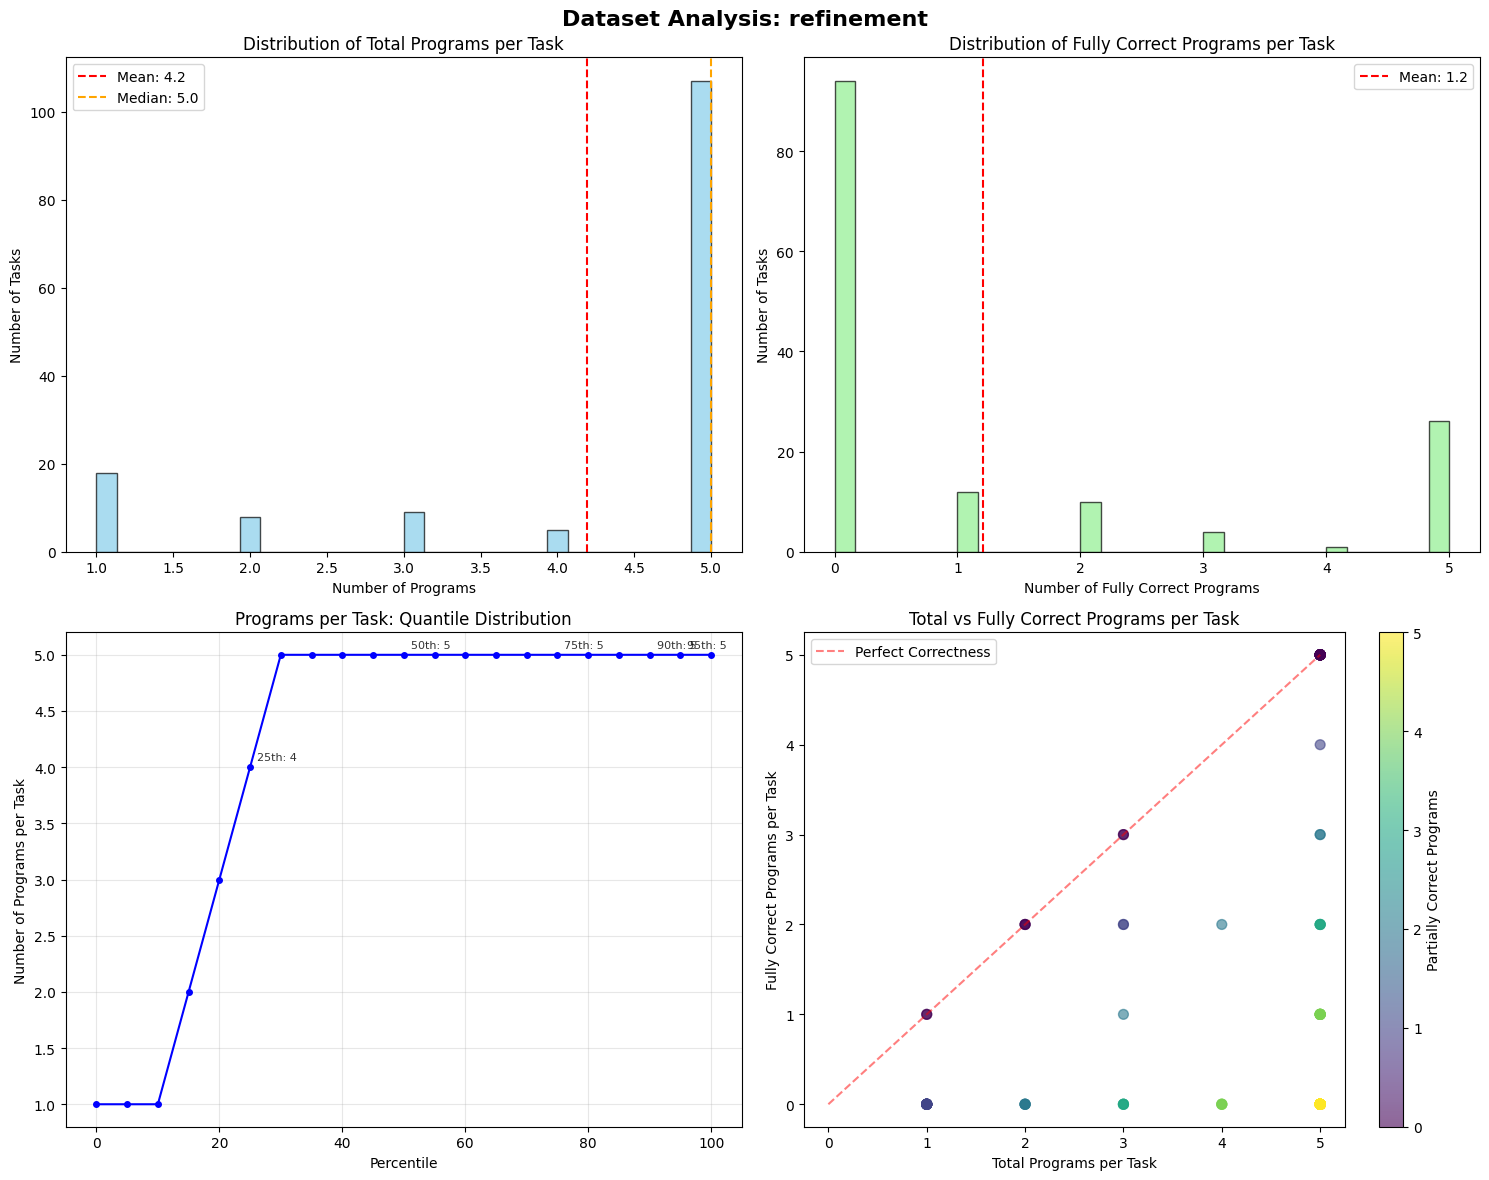


✓ Analysis complete! Generated visualizations showing:
   • Program distribution patterns across tasks
   • Quantile distribution of programs per task
   • Relationship between total and correct programs per task


In [34]:
from llm_python.datasets.statistics import analyze_dataset_statistics

analyze_dataset_statistics(df, "refinement")

In [35]:
sample = df[["code_original", "code"]].sample(n=10, random_state=42)
for idx, row in sample.iterrows():
    print(f"Row {idx}:")
    print("Original code:\n", row["code_original"])
    print("Refined code:\n", row["code"])
    print("-" * 80)

Row 15325:
Original code:
 <NA>
Refined code:
 def transform(grid_lst: list[list[int]]) -> list[list[int]]:
    grid = [row[:] for row in grid_lst]
    height = len(grid)
    width = len(grid[0])
    positions = [(y, x) for y in range(height) for x in range(width) if grid[y][x] != 0]
    if not positions:
        return grid
    color = grid[positions[0][0]][positions[0][1]]
    min_y = min((pos[0] for pos in positions))
    max_y = max((pos[0] for pos in positions))
    min_x = min((pos[1] for pos in positions))
    max_x = max((pos[1] for pos in positions))
    center_y = (min_y + max_y) // 2
    center_x = (min_x + max_x) // 2
    max_distance = max(center_y - min_y, max_y - center_y, center_x - min_x, max_x - center_x)
    if max_distance == 0:
        max_distance = 1
    for y in range(height):
        for x in range(width):
            if grid[y][x] == 0:
                distance = max(abs(y - center_y), abs(x - center_x))
                if distance % max_distance == 0:
       